# CS 6330
## Final Project
## Distinguish Between Sitting, Walking, and Stair Climbing
### Robert Burkhardt
### Dan Olson
### Rich Lukas
### 2/14/23

### Load Libraries

In [1]:
from collections import defaultdict as dd
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from ModelAuto.Multicollinearity import handel_Multico_VIF
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from numpy import *
from numpy import linalg as LA
from patsy import dmatrices
from pylab import *
from scipy import signal
from scipy.sparse import csr_matrix, find
from scipy.stats import chisquare
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import rand_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import scipy as sci
import scipy.stats as stats
import seaborn as sns
import sklearn
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import statistics 
import statsmodels.api as sm
import tensorflow as tf
import time
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
print("Libraries Loaded")

Libraries Loaded


### Set up dataframes

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# !!! ONLY RUN THIS CELL ONCE
# RESTART NOTEBOOK IF RUN MORE THAN ONCE
notebook_path = os.path.abspath("")


## Helper functions

In [3]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError( "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y


def smooth_demo():

    t=linspace(-4,4,100)
    x=sin(t)
    xn=x+randn(len(t))*0.1
    y=smooth(x)

    ws=31

    subplot(211)
    plot(ones(ws))

    windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

    hold(True)
    for w in windows[1:]:
        eval('plot('+w+'(ws) )')

    axis([0,30,0,1.1])

    legend(windows)
    title("The smoothing windows")
    subplot(212)
    plot(x)
    plot(xn)
    for w in windows:
        plot(smooth(xn,10,w))
    l=['original signal', 'signal with noise']
    l.extend(windows)

    legend(l)
    title("Smoothing a noisy signal")
    show()

def gauss_kern(size, sizey=None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = mgrid[-size:size+1, -sizey:sizey+1]
    g = exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

def blur_image(im, n, ny=None) :
    """ blurs the image by convolving with a gaussian kernel of typical
        size n. The optional keyword argument ny allows for a different
        size in the y direction.
    """
    g = gauss_kern(n, sizey=ny)
    improc = signal.convolve(im,g, mode='valid')
    return(improc)

#!python
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError( msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

import os
 
# Function to Get the current
# working directory
def current_path():
    print("Current working directory before")
    print(os.getcwd())
    print()

##  Read in Data files into a combined dataframe

In [4]:
#display(HTML("<script>$('div.cell.selected').children('div.output_wrapper').height(800);</script>"))
df_stairs = pd.DataFrame(columns  = ['time','gFx','gFy','gFz','wx','wy','wz'])
df_walking = pd.DataFrame(columns = ['time','gFx','gFy','gFz','wx','wy','wz'])
df_sitting = pd.DataFrame(columns = ['time','gFx','gFy','gFz','wx','wy','wz'])

data_path = os.path.join(notebook_path, "data\\richard-raw\\Logs_climbing_stairs")
os.chdir(data_path)
# Get the list of all files and directories
for x in os.listdir():
    if x.endswith(".csv"):
        df = pd.read_csv(x)
#        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'S'
        df_stairs = df_stairs.append(df, ignore_index=True) 
#df_stairs = df_stairs.drop('Unnamed: 7', axis=1) 
df_stairs.reset_index(inplace = True,drop=True)
df_stairs = df_stairs.dropna(axis = 0, how ='any')

data_path = os.path.join(notebook_path, "data\\richard-raw\\Logs_walking_straight")
os.chdir(data_path)
#os.chdir('./Walking')
# Get the list of all files and directories
for x in os.listdir():
    if x.endswith(".csv"):
        df = pd.read_csv(x)
#        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'W'
        df_walking = df_walking.append(df, ignore_index=True) 
#df_walking = df_walking.drop('Unnamed: 7', axis=1) 
df_walking = df_walking.dropna(axis = 0, how ='any')
df_walking.reset_index(inplace = True,drop=True)

data_path = os.path.join(notebook_path, "data\\richard-raw\\Logs_sitting")
os.chdir(data_path)
#os.chdir('C:/msoe/CC6330/Projects/VIrtual/env/Final/cs6330-final-project/data/richard-raw/Sitting')
#os.chdir('./Sitting')
# Get the list of all files and directories
for x in os.listdir():
    if x.endswith(".csv"):
        df = pd.read_csv(x)
#        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'C' #sitting
        df_sitting = df_sitting.append(df, ignore_index=True) 
#df_sitting = df_sitting.drop('Unnamed: 7', axis=1) 
df_sitting = df_sitting.dropna(axis = 0, how ='any')
df_sitting.reset_index(inplace = True,drop=True)

df_combined = pd.concat([df_walking, df_stairs, df_sitting])
df_combined = df_combined.drop('time', axis=1)
#df_combined3 = df_combined3.drop('time_elapsed', axis=1)
df_combined.reset_index(inplace = True,drop=True)

df_combined.head()

,gFx,gFy,gFz,wx,wy,wz,type
0,-0.1600,0.2941,1.0473,0.0,0.0,0.0,W
1,-0.1671,0.2949,1.0448,0.0,0.0,0.0,W
2,-0.1717,0.2985,1.0392,0.0,0.0,0.0,W
3,-0.1788,0.2990,1.0324,0.0,0.0,0.0,W
4,-0.1861,0.2985,1.0238,0.0,0.0,0.0,W


### Perform Truncated SVD

Select n = 3 components

The size of the X_svd is 61464 by 4

The explained_variance is  [3.14566143 1.49325649 0.48846288 0.43777855]

The explained_variance_ratio is  [0.52126946 0.24744844 0.08094348 0.07254455]

The explained_variance_ratio_.sum() is  0.9222059299213528

The trun_svd.singular_values  [442.09565017 314.34194661 256.35155377 165.02025763]

The n_features_in_ is  6


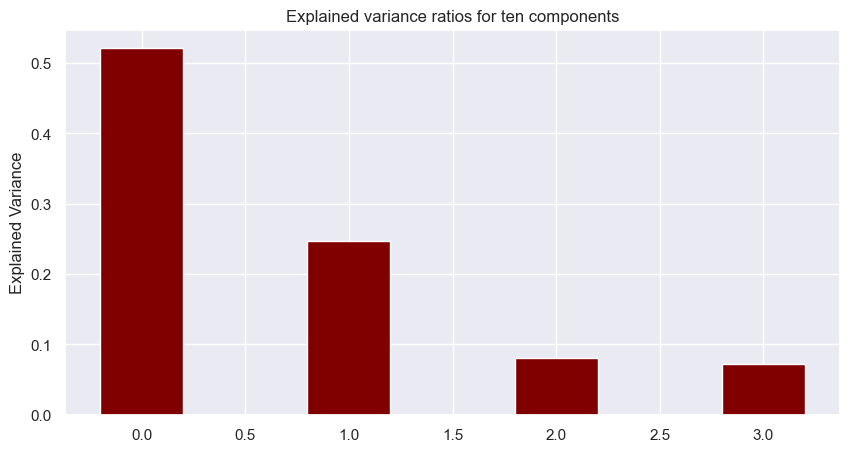

In [5]:
X_matrix = df_combined[['gFx','gFy','gFz','wx','wy','wz']]
y = df_combined.type

trun_svd =  TruncatedSVD(n_components = 4)
print("Select n = 3 components")
X_svd = trun_svd.fit_transform(X_matrix)
print('\nThe size of the X_svd is ' + str(X_svd.shape[0]) + ' by ' + str(X_svd.shape[1]) )
print("\nThe explained_variance is ",trun_svd.explained_variance_)
print("\nThe explained_variance_ratio is ",trun_svd.explained_variance_ratio_)
x = trun_svd.explained_variance_ratio_
print("\nThe explained_variance_ratio_.sum() is ",trun_svd.explained_variance_ratio_.sum())
print("\nThe trun_svd.singular_values ", trun_svd.singular_values_) #n_features_in_
print("\nThe n_features_in_ is ", trun_svd.n_features_in_) #n_features_in_
#print("feature_names_in_ ", trun_svd.feature_names_in_) #n_features_in_

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(range(0,len(trun_svd.explained_variance_ratio_)), trun_svd.explained_variance_ratio_, color ='maroon', width = 0.4)
plt.ylabel("Components")
plt.ylabel("Explained Variance")
plt.title("Explained variance ratios for ten components")
plt.show()

### Plot 2D Clusters

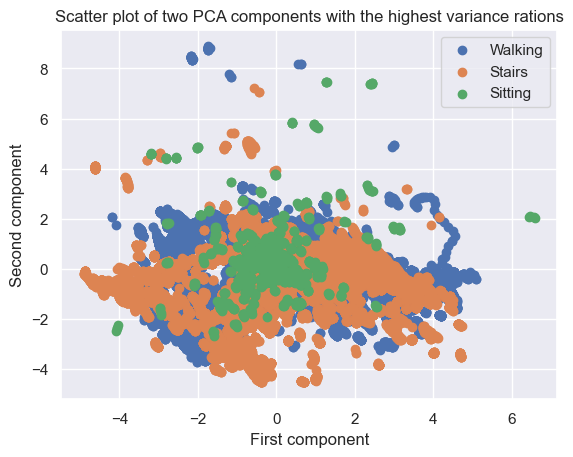

In [6]:
#X_proj = trun_svd.transform(X_matrix)
#print(X_proj.shape[0])
I= df_combined[df_combined['type']=='W'].index
J= df_combined[df_combined['type']=='S'].index
K= df_combined[df_combined['type']=='C'].index
#print(max(I))
plt.scatter(X_svd[I, 0], X_svd[I, 1])
plt.scatter(X_svd[J, 0], X_svd[J, 1])
plt.scatter(X_svd[K, 0], X_svd[K, 1])
plt.title('Scatter plot of two PCA components with the highest variance rations')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend(["Walking","Stairs","Sitting"])

plt.show()
#X_svd

### Test Train Stratified split with Scaling

In [7]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_combined.copy(deep = True)
#Xval = df_walking1.copy(deep = True)

if True:
    X['gFxm1'] = X['gFx']
    X['gFym1'] = X['gFy']
    X['gFzm1'] = X['gFz']

    X['gFxm1'].iloc[1:] = X['gFx'].iloc[0:-1]
    X['gFym1'].iloc[1:] = X['gFy'].iloc[0:-1]
    X['gFzm1'].iloc[1:] = X['gFz'].iloc[0:-1]

if True:
    X['wxm1'] = X['wx']
    X['wym1'] = X['wy']
    X['wzm1'] = X['wz']

    X['wxm1'].iloc[1:] = X['wx'].iloc[0:-1]
    X['wym1'].iloc[1:] = X['wy'].iloc[0:-1]
    X['wzm1'].iloc[1:] = X['wz'].iloc[0:-1]
    
if True:
    X['wxE'] = X['wx']
    X['wyE'] = X['wy']
    X['wzE'] = X['wz']
   
    alpha = 0.1
    for i in range(1,len(X['wx'])):
        X['wxE'].loc[i] = round(alpha*X['wx'].loc[i] + (1-alpha)*X['wxE'].loc[i-1],4)
        X['wyE'].loc[i] = round(alpha*X['wy'].loc[i] + (1-alpha)*X['wyE'].loc[i-1],4)
        X['wzE'].loc[i] = round(alpha*X['wz'].loc[i] + (1-alpha)*X['wzE'].loc[i-1],4)

if True:

    X['gFxE'] = X['gFx']
    X['gFyE'] = X['gFy']
    X['gFzE'] = X['gFz'] 
    
    alpha = 0.1
    for i in range(1,len(X['wx'])):
        X['gFxE'].loc[i] = round(alpha*X['gFx'].loc[i] + (1-alpha)*X['gFxE'].loc[i-1],4)
        X['gFyE'].loc[i] = round(alpha*X['gFy'].loc[i] + (1-alpha)*X['gFyE'].loc[i-1],4)
        X['gFzE'].loc[i] = round(alpha*X['gFz'].loc[i] + (1-alpha)*X['gFzE'].loc[i-1],4)


y = X.pop('type')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

c:\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



The size of the X_train is 46098 by 18

The size of the X_test is 15366 by 18


### Create Correlation Matrix

Correlation Matrix is : 
            gFx       gFy       gFz        wx        wy        wz     gFxm1  \
gFx    1.000000  0.207249  0.080644  0.104348  0.026267  0.285049  0.991836   
gFy    0.207249  1.000000  0.272668 -0.118852 -0.217119 -0.065908  0.212359   
gFz    0.080644  0.272668  1.000000 -0.155958  0.035814 -0.013671  0.086622   
wx     0.104348 -0.118852 -0.155958  1.000000  0.295708  0.493282  0.102153   
wy     0.026267 -0.217119  0.035814  0.295708  1.000000  0.129123  0.026025   
wz     0.285049 -0.065908 -0.013671  0.493282  0.129123  1.000000  0.283379   
gFxm1  0.991836  0.212359  0.086622  0.102153  0.026025  0.283379  1.000000   
gFym1  0.201117  0.993017  0.270820 -0.116055 -0.218487 -0.061557  0.207236   
gFzm1  0.076380  0.268263  0.985022 -0.156356  0.026563 -0.012591  0.080629   
wxm1   0.106540 -0.121624 -0.155528  0.990163  0.298008  0.493719  0.104348   
wym1   0.026492 -0.215715  0.045120  0.290271  0.978067  0.122053  0.026268   
wzm1   0.286709 -0.070330 -

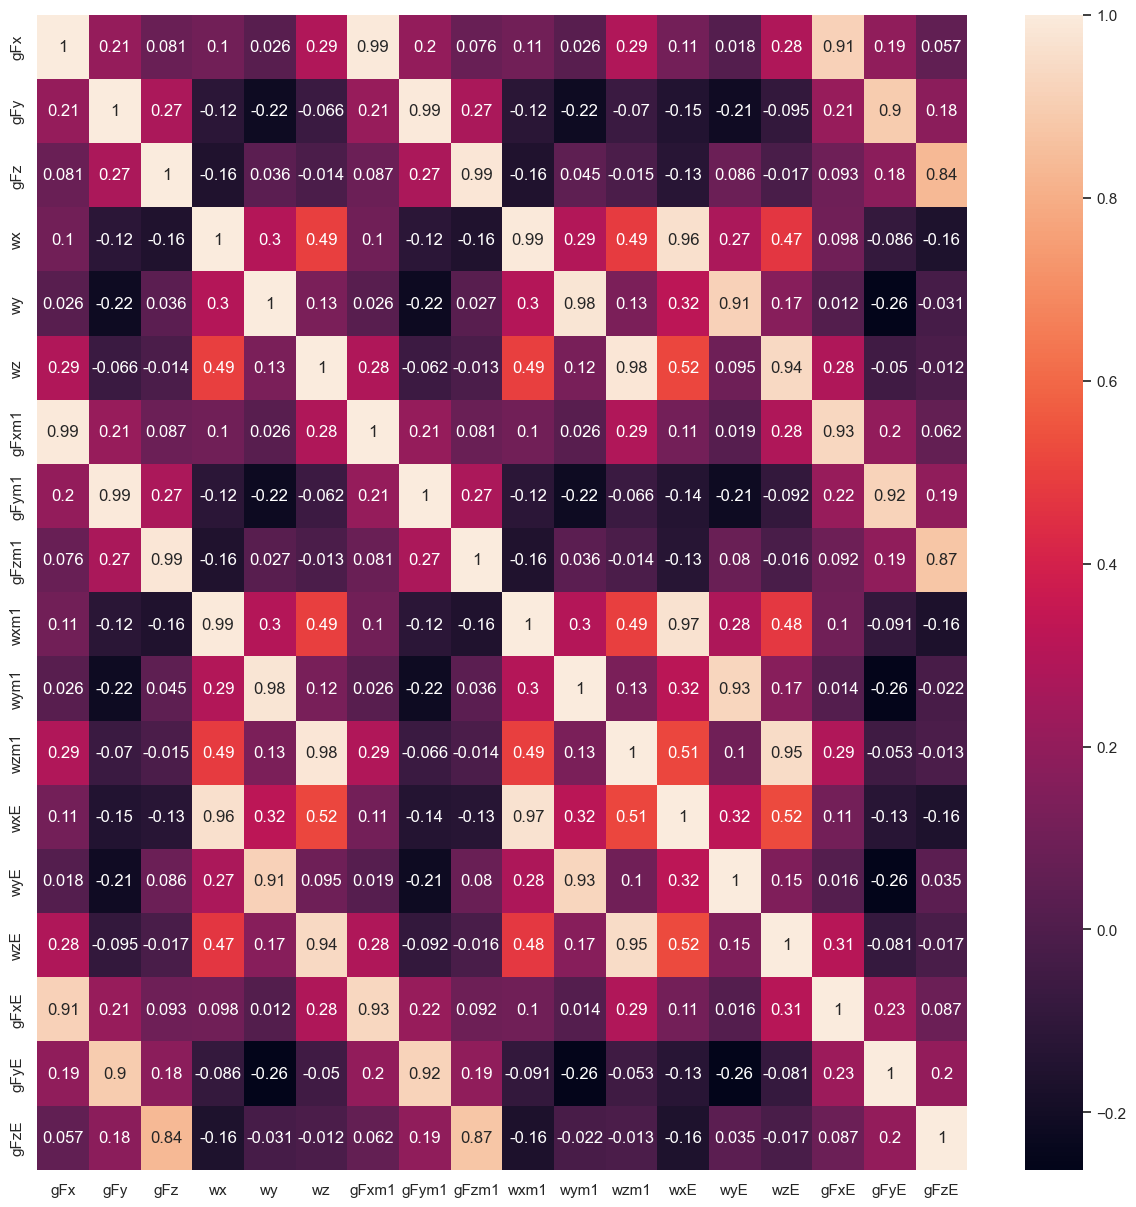

In [8]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

matrix = X.corr()
 
# print correlation matrix
print("Correlation Matrix is : ")
print(matrix)
plt.figure(figsize=(15, 15))
sn.heatmap(matrix, annot=True)
#plt.figure(figsize=(12, 20))
plt.show()

## Create Full Feature set

In [9]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_combined.copy(deep = True)
#Xval = df_walking1.copy(deep = True)

if True:
    X['gFxm1'] = X['gFx']
    X['gFym1'] = X['gFy']
    X['gFzm1'] = X['gFz']

    X['gFxm1'].iloc[1:] = X['gFx'].iloc[0:-1]
    X['gFym1'].iloc[1:] = X['gFy'].iloc[0:-1]
    X['gFzm1'].iloc[1:] = X['gFz'].iloc[0:-1]

if True:
    X['wxm1'] = X['wx']
    X['wym1'] = X['wy']
    X['wzm1'] = X['wz']

    X['wxm1'].iloc[1:] = X['wx'].iloc[0:-1]
    X['wym1'].iloc[1:] = X['wy'].iloc[0:-1]
    X['wzm1'].iloc[1:] = X['wz'].iloc[0:-1]
    
if True:
    X['wxE'] = X['wx']
    X['wyE'] = X['wy']
    X['wzE'] = X['wz']
   
    alpha = 0.1
    for i in range(1,len(X['wx'])):
        X['wxE'].loc[i] = round(alpha*X['wx'].loc[i] + (1-alpha)*X['wxE'].loc[i-1],4)
        X['wyE'].loc[i] = round(alpha*X['wy'].loc[i] + (1-alpha)*X['wyE'].loc[i-1],4)
        X['wzE'].loc[i] = round(alpha*X['wz'].loc[i] + (1-alpha)*X['wzE'].loc[i-1],4)

if True:

    X['gFxE'] = X['gFx']
    X['gFyE'] = X['gFy']
    X['gFzE'] = X['gFz'] 
    
    alpha = 0.1
    for i in range(1,len(X['wx'])):
        X['gFxE'].loc[i] = round(alpha*X['gFx'].loc[i] + (1-alpha)*X['gFxE'].loc[i-1],4)
        X['gFyE'].loc[i] = round(alpha*X['gFy'].loc[i] + (1-alpha)*X['gFyE'].loc[i-1],4)
        X['gFzE'].loc[i] = round(alpha*X['gFz'].loc[i] + (1-alpha)*X['gFzE'].loc[i-1],4)


y = X.pop('type')
X.pop('gFx')
X.pop('gFy')
X.pop('gFz')

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

c:\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



The size of the X_train is 46098 by 15

The size of the X_test is 15366 by 15


### Perform Logistic Classification

c:\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Score:  1.0
Accuracy:  0.6824157230248601
Balanced Accuracy:  0.7125583596664194
f1_score 0.6656000239440398
      C     W     S
C  3011    46     9
W   189  5499  1382
S   157  3097  1976


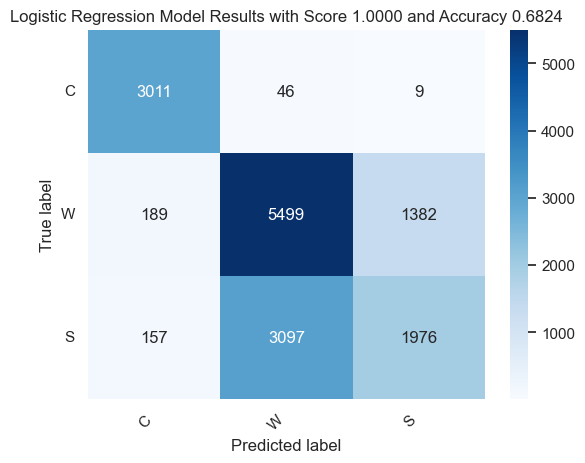

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto').fit(X_train, y_train)
yhat = LR.predict(X_test )

Score_model = round(LR.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
print("Score: ", round(LR.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, yhat))
print('f1_score', f1_score(y_test, yhat,average = 'weighted'))

conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(LR.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('Logistic Regression Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
plt.show() 



### Create Labels for CART

In [11]:
Xlabels = X.copy(deep = True)

### Perform SVM Classification

#### This works poorly

c:\python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Score:  1.0
Accuracy:  0.6583365872705974
Balanced Accuracy:  0.6869145912619348
f1_score 0.6264513901242525
      C     W     S
C  3019     6    41
W   410  5645  1015
S   192  3586  1452


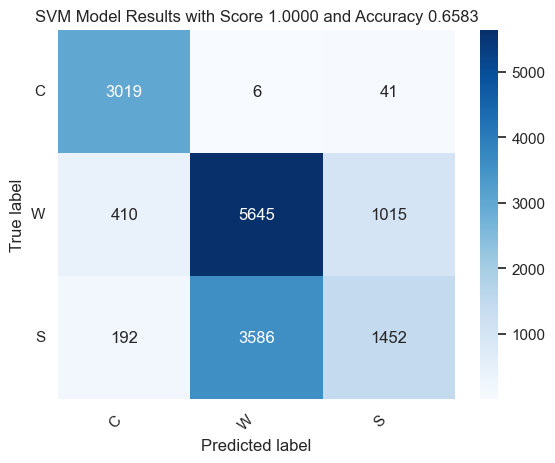

In [12]:
from sklearn import svm

SVM = svm.LinearSVC()
SVM.fit(X_train, y_train)
yhat = SVM.predict(X_test )
print("Score: ", round(SVM.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, yhat))
print('f1_score', f1_score(y_test, yhat,average = 'weighted'))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(SVM.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('SVM Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('SVM Model Results')
plt.show() 




### Perform Random Forest Classification

#### This works slightly better

Score:  1.0
Accuracy:  0.9271768840296759
Balanced Accuracy:  0.9304183791400211
f1_score 0.9261751945229982
      C     W     S
C  3046    16     4
W    10  6911   149
S    11   929  4290


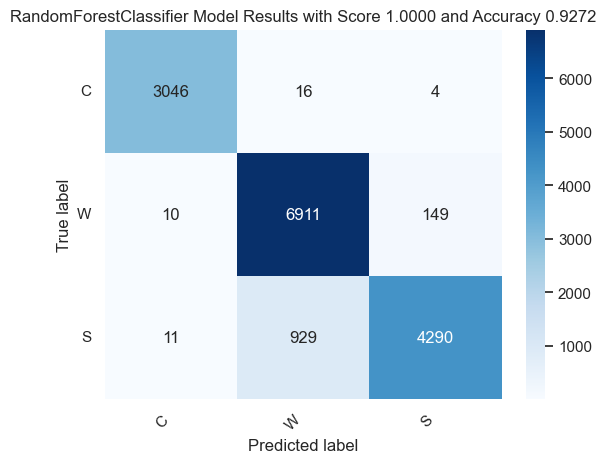

In [13]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0)
RF.fit(X_train, y_train)
yhat = RF.predict(X_test)
print("Score: ", round(RF.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, yhat))
print('f1_score', f1_score(y_test, yhat,average = 'weighted'))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(RF.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('RandomForestClassifier Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('RandomForestClassifier Model Results')
plt.show() 




## Decision Tree

Score:  1.0
Accuracy:  0.9815827150852532
Balanced Accuracy:  0.9835463939504598
f1_score 0.9815819033616596
      C     W     S
C  3054     5     7
W     5  6942   123
S     3   140  5087


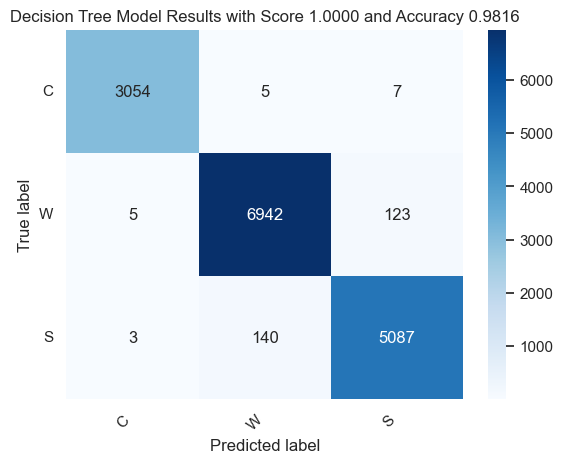

Feature: 0, Score: 0.01993
Feature: 1, Score: 0.03177
Feature: 2, Score: 0.03566
Feature: 3, Score: 0.02251
Feature: 4, Score: 0.02747
Feature: 5, Score: 0.02432
Feature: 6, Score: 0.03600
Feature: 7, Score: 0.02525
Feature: 8, Score: 0.02001
Feature: 9, Score: 0.08098
Feature: 10, Score: 0.03767
Feature: 11, Score: 0.04531
Feature: 12, Score: 0.22398
Feature: 13, Score: 0.16879
Feature: 14, Score: 0.20035


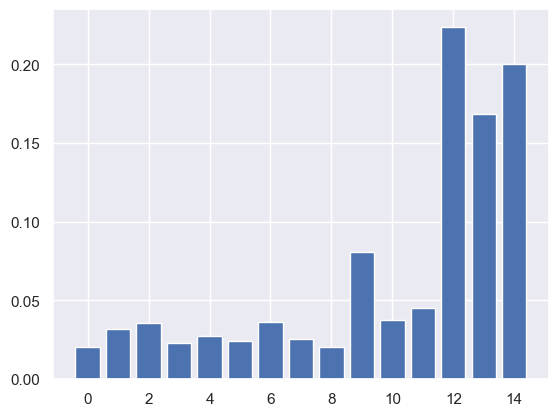

The top Feature importances are:

gFxE, Score: 0.224
gFzE, Score: 0.2
gFyE, Score: 0.169
wxE, Score: 0.081
wzE, Score: 0.045
wyE, Score: 0.038
wxm1, Score: 0.036
wz, Score: 0.036
wy, Score: 0.032
gFym1, Score: 0.027
wym1, Score: 0.025
gFzm1, Score: 0.024
gFxm1, Score: 0.023
wzm1, Score: 0.02
wx, Score: 0.02


In [14]:
CLF = DecisionTreeClassifier()
CLF.fit(X_train, y_train)
yhat = CLF.predict(X_test)
print("Score: ", round(CLF.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, yhat))
print('f1_score', f1_score(y_test, yhat,average = 'weighted'))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(CLF.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('Decision Tree Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('RandomForestClassifier Model Results')
plt.show() 

importance = CLF.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Output importances 
imp_list = []
for i,v in enumerate(importance):
    imp_list.append((i, v))
sorted_list = sorted(imp_list, key=lambda x: x[1], reverse=True)
print('The top Feature importances are:' '\n')
for f, i in sorted_list[:16]:
    print(f'{Xlabels.columns[f]}, Score: {round(i, 3)}')


## K Nearest Neighbor

Score:  1.0
Accuracy:  0.9946635428868932
Balanced Accuracy:  0.9950939447796747
f1_score 0.9946637981410467
      C     W     S
C  3058     3     5
W    15  7029    26
S    10    23  5197


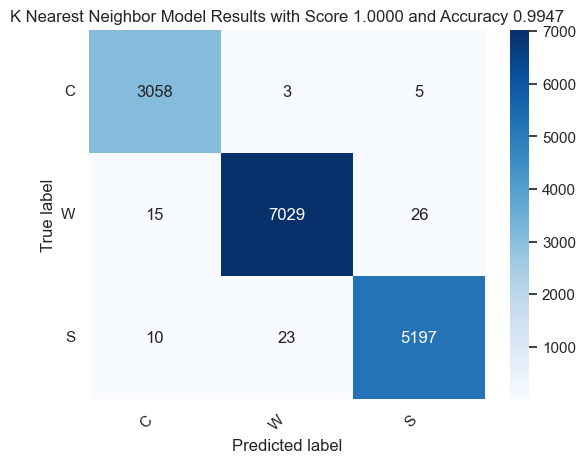

In [15]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
yhat = neigh.predict(X_test)
print("Score: ", round(neigh.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, yhat))
print('f1_score', f1_score(y_test, yhat,average = 'weighted'))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(neigh.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('K Nearest Neighbor Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('RandomForestClassifier Model Results')
plt.show() 




### MLP Classifier

#### This works quite well, but needs tuning

c:\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Score:  1.0
Accuracy:  0.906286606794221
Balanced Accuracy:  0.9137772407078352
f1_score 0.9060052330862483


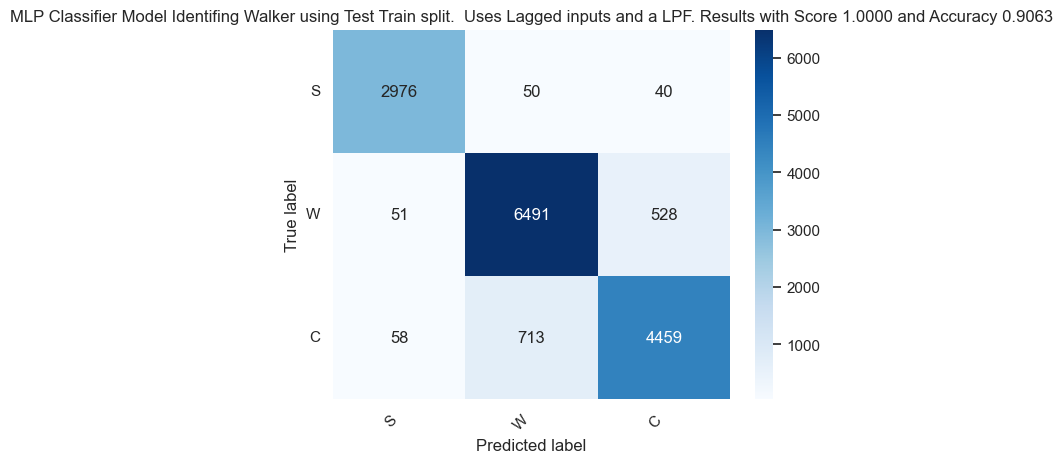

In [16]:
from sklearn.neural_network import MLPClassifier
# {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', random_state=1,'solver': 'lbfgs'}
NN = MLPClassifier(activation = "relu", solver='sgd', alpha=0.0001, hidden_layer_sizes=(100, ), learning_rate = "constant", max_iter=100, shuffle = True, early_stopping = True)
#NN = MLPClassifier(activation = "relu", solver='sgd', alpha=0.0001, hidden_layer_sizes=(100, ), learning_rate = "constant", max_iter=100, shuffle = True, early_stopping = True)
NN.fit(X_train, y_train)
yhat = NN.predict(X_test)
print("Score: ", round(NN.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, yhat))
print('f1_score', f1_score(y_test, yhat,average = 'weighted'))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
classnames.reverse()
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

#print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(NN.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('MLP Classifier Model Identifing Walker using Test Train split.  Uses Lagged inputs and a LPF. Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
plt.show() 

## Data Set with Reduced Features

In [17]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_combined.copy(deep = True)
#Xval = df_walking1.copy(deep = True)

if False:
    X = X.drop('wx', axis=1) 
    X = X.drop('wy', axis=1) 
    X = X.drop('wz', axis=1) 
    
if True:
    X = X.drop('gFx', axis=1) 
    X = X.drop('gFy', axis=1) 
    X = X.drop('gFz', axis=1) 

if False:
    X['gFxm1'] = X['gFx']
    X['gFym1'] = X['gFy']
    X['gFzm1'] = X['gFz']

    X['gFxm1'].iloc[1:] = X['gFx'].iloc[0:-1]
    X['gFym1'].iloc[1:] = X['gFy'].iloc[0:-1]
    X['gFzm1'].iloc[1:] = X['gFz'].iloc[0:-1]

if True:
    X['wxm1'] = X['wx']
    X['wym1'] = X['wy']
    X['wzm1'] = X['wz']

    X['wxm1'].iloc[1:] = X['wx'].iloc[0:-1]
    X['wym1'].iloc[1:] = X['wy'].iloc[0:-1]
    X['wzm1'].iloc[1:] = X['wz'].iloc[0:-1]
    
if False:
    X['wxE'] = X['wx']
    X['wyE'] = X['wy']
    X['wzE'] = X['wz']
   
    alpha = 0.1
    for i in range(1,len(X['wx'])):
        X['wxE'].loc[i] = round(alpha*X['wx'].loc[i] + (1-alpha)*X['wxE'].loc[i-1],4)
        X['wyE'].loc[i] = round(alpha*X['wy'].loc[i] + (1-alpha)*X['wyE'].loc[i-1],4)
        X['wzE'].loc[i] = round(alpha*X['wz'].loc[i] + (1-alpha)*X['wzE'].loc[i-1],4)

if False:

    X['gFxE'] = X['gFx']
    X['gFyE'] = X['gFy']
    X['gFzE'] = X['gFz'] 
    
    alpha = 0.1
    for i in range(1,len(X['wx'])):
        X['gFxE'].loc[i] = round(alpha*X['gFx'].loc[i] + (1-alpha)*X['gFxE'].loc[i-1],4)
        X['gFyE'].loc[i] = round(alpha*X['gFy'].loc[i] + (1-alpha)*X['gFyE'].loc[i-1],4)
        X['gFzE'].loc[i] = round(alpha*X['gFz'].loc[i] + (1-alpha)*X['gFzE'].loc[i-1],4)


y = X.pop('type')

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



The size of the X_train is 46098 by 6

The size of the X_test is 15366 by 6


c:\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Create training data with reduced features

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



The size of the X_train is 46098 by 6

The size of the X_test is 15366 by 6


## LR with Reduced Features

Score:  1.0
Accuracy:  0.49251594429259404
Balanced Accuracy:  0.3683362139838265
f1_score 0.37098711801946543
    C     W    S
C   1  3036   29
W  22  6876  172
S   1  4538  691


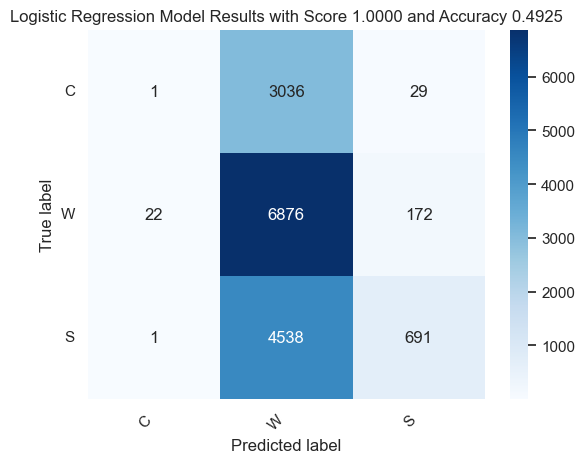

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto').fit(X_train, y_train)
yhat = LR.predict(X_test )

Score_model = round(LR.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
print("Score: ", round(LR.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, yhat))
print('f1_score', f1_score(y_test, yhat,average = 'weighted'))

conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(LR.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('Logistic Regression Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
plt.show() 



## KNN With Reduced Features

### Reduced data set based on CART analysis

In [20]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_combined.copy(deep = True)
#Xval = df_walking1.copy(deep = True)

if False:
    X = X.drop('wx', axis=1) 
    X = X.drop('wy', axis=1) 
    X = X.drop('wz', axis=1) 
    
if False:
    X = X.drop('gFx', axis=1) 
    X = X.drop('gFy', axis=1) 
    X = X.drop('gFz', axis=1) 

if False:
    X['gFxm1'] = X['gFx']
    X['gFym1'] = X['gFy']
    X['gFzm1'] = X['gFz']

    X['gFxm1'].iloc[1:] = X['gFx'].iloc[0:-1]
    X['gFym1'].iloc[1:] = X['gFy'].iloc[0:-1]
    X['gFzm1'].iloc[1:] = X['gFz'].iloc[0:-1]

if False:
    X['wxm1'] = X['wx']
    X['wym1'] = X['wy']
    X['wzm1'] = X['wz']

    X['wxm1'].iloc[1:] = X['wx'].iloc[0:-1]
    X['wym1'].iloc[1:] = X['wy'].iloc[0:-1]
    X['wzm1'].iloc[1:] = X['wz'].iloc[0:-1]
    
if True:
    X['wxE'] = X['wx']
    X['wyE'] = X['wy']
    X['wzE'] = X['wz']
   
    alpha = 0.1
    for i in range(1,len(X['wx'])):
        X['wxE'].loc[i] = round(alpha*X['wx'].loc[i] + (1-alpha)*X['wxE'].loc[i-1],4)
        X['wyE'].loc[i] = round(alpha*X['wy'].loc[i] + (1-alpha)*X['wyE'].loc[i-1],4)
        X['wzE'].loc[i] = round(alpha*X['wz'].loc[i] + (1-alpha)*X['wzE'].loc[i-1],4)
if True:
    X = X.drop('wx', axis=1) 
    X = X.drop('wy', axis=1) 
    X = X.drop('wz', axis=1) 
        
if True:
    X['gFxE'] = X['gFx']
    X['gFyE'] = X['gFy']
    X['gFzE'] = X['gFz'] 
    
    alpha = 0.1
    for i in range(1,len(X['gFx'])):
        X['gFxE'].loc[i] = round(alpha*X['gFx'].loc[i] + (1-alpha)*X['gFxE'].loc[i-1],4)
        X['gFyE'].loc[i] = round(alpha*X['gFy'].loc[i] + (1-alpha)*X['gFyE'].loc[i-1],4)
        X['gFzE'].loc[i] = round(alpha*X['gFz'].loc[i] + (1-alpha)*X['gFzE'].loc[i-1],4)

if True:
    X = X.drop('gFx', axis=1) 
    X = X.drop('gFy', axis=1) 
    X = X.drop('gFz', axis=1) 

y = X.pop('type')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


c:\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



The size of the X_train is 46098 by 6

The size of the X_test is 15366 by 6


### KNN with reduced Features

Score:  1.0
Accuracy:  0.9918651568397762
Balanced Accuracy:  0.9927843476762729
f1_score 0.991860779920099
      C     W     S
C  3065     1     0
W     8  7022    40
S     0    76  5154


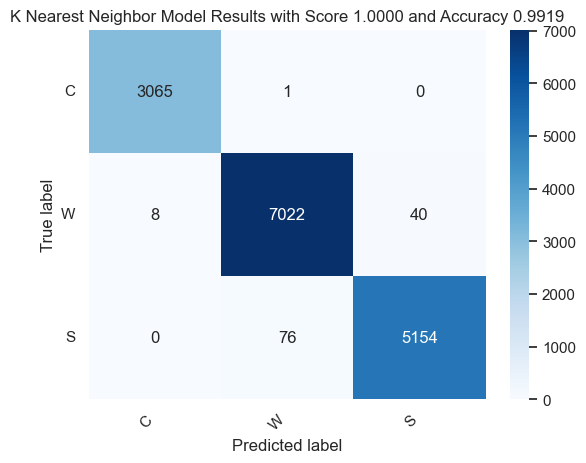

In [21]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
yhat = neigh.predict(X_test)
print("Score: ", round(neigh.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, yhat))
print('f1_score', f1_score(y_test, yhat,average = 'weighted'))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(neigh.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('K Nearest Neighbor Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('RandomForestClassifier Model Results')
plt.show() 




## Grid Search Method to find optimal hyper parameters
## This takes a long time to run

In [22]:
if False:  # Disable to prevent cell from running for hours
    
    from sklearn.neural_network import MLPClassifier
    mlp = MLPClassifier(max_iter=1000,early_stopping = True)

    parameter_space = {
        'hidden_layer_sizes': [(10,),(50,), (75,), (100,), (125,)],
        'activation': ['tanh', 'relu','logistic'],
        'solver': ['sgd', 'adam','lbfgs'],
        'alpha': [0.00001,0.0001,0.001,0.01, 0.05],
        'learning_rate': ['constant','adaptive'],
    }

    from sklearn.model_selection import GridSearchCV

    clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)

    # Best paramete set
    print('Best parameters found:\n', clf.best_params_)

    # All results
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    y_true, y_pred = y_test , clf.predict(X_test)

    from sklearn.metrics import classification_report
    print('Results on the test set:')
    print(classification_report(y_true, y_pred))

    plt.figure()
    heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    Score_model = round(NN.score(X_test,y_pred), 4)
    Accuracy_model = round(accuracy_score(y_test, y_pred),4)
    plt.title('MLP Classifier Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
    #plt.title('MLPClassifier Model Results')
    plt.show()